In this notebook, we calculate the feature importance for a few tree-based ensemble methods, for the problem of predicting photometric redshifts from six photometric bands (u, g, r, i, z, y).

It accompanies Chapter 6 of the book (4 of 4).

Copyright: Viviana Acquaviva (2023); see also other data credits below.

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

The problem is inspired by [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

We read in the selection of data as in previous notebooks.

In [ ]:
sel_features = pd.read_csv('sel_features.csv', sep = '\t')

In [ ]:
sel_target = pd.read_csv('sel_target.csv')

In [ ]:
sel_features.shape

(6307, 6)

In [ ]:
sel_target.values.ravel() #changes shape to 1d row-like array

array([1.0034, 0.9023, 0.4242, ..., 0.3703, 0.371 , 0.7333])

### Let's start with Random Forests

In [ ]:
model = RandomForestRegressor(max_features=4, n_estimators=200) #I need to re-seed the random state

After the model has been fit, it will have the attribute "feature\_importances\_". We can look at the feature importance using the following code:

In [ ]:
model.fit(sel_features, sel_target.values.ravel()) 

#note: this is not doing any train/test split, but fitting the entire data set 

RandomForestRegressor(max_features=4, n_estimators=200)

In [ ]:
model.feature_importances_

array([0.2041467 , 0.14265748, 0.29727102, 0.14435894, 0.09618153,
       0.11538434])

The code below plots the feature importances.

Feature ranking:
1. feature: r_apercor, 2 (0.297271)
2. feature: u_apercor, 0 (0.204147)
3. feature: i_apercor, 3 (0.144359)
4. feature: g_apercor, 1 (0.142657)
5. feature: y_apercor, 5 (0.115384)
6. feature: z_apercor, 4 (0.096182)


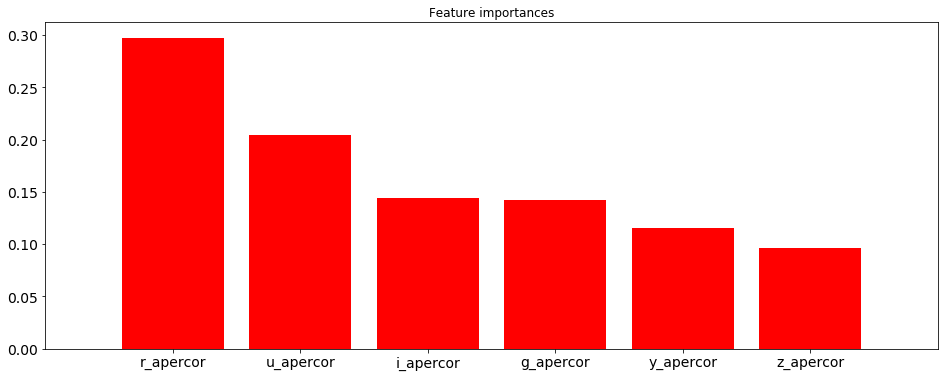

In [ ]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(sel_features.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, sel_features.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(sel_features.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(sel_features.shape[1]), sel_features.columns[indices])
plt.xlim([-1, sel_features.shape[1]])
plt.show()

### In this problem, all the features are quite important, which is somewhat expected because there are only 6 of them. In many other cases, when we have more features with a high degree of redundancy, we'll find that many features have negligible importance, and this can be useful as a feature selection tool.

### Something we can do is to compare with the results of other algorithms.

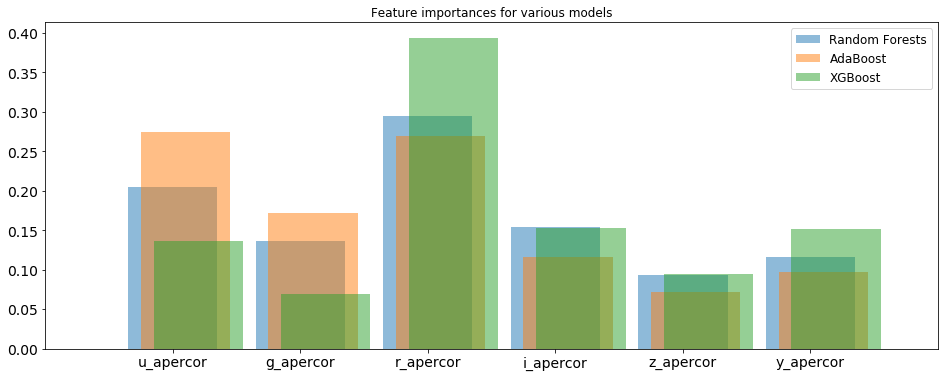

In [ ]:
# Plot the feature importances of three models

plt.figure(figsize=(16,6))

plt.title("Feature importances for various models")

models = [RandomForestRegressor(max_features=4, n_estimators=200), \
          AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None), n_estimators=100), 
          xgb.XGBRegressor(objective ='reg:squarederror', max_depth=6, n_estimators = 500, learning_rate=0.1)]

model_names = ['Random Forests', 'AdaBoost', 'XGBoost']

for i, model in enumerate(models):

    model.fit(sel_features, sel_target.values.ravel()) 
    
    importances = model.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    plt.bar(np.arange(sel_features.shape[1])+0.1*i, importances, 
            align="center", width=0.7, alpha = 0.5, label = model_names[i])
    
    plt.xticks(range(sel_features.shape[1]), sel_features.columns)
    
    plt.xlim([-1, sel_features.shape[1]])
    
    plt.legend(fontsize = 12)   
    

### This is a reminder that feature importance is an indication only, and it is often algorithm-dependent.

My take-home message is that these methods are usually quite reliable if one wants to select a set of features that provide a certain performance, but that the ranking of features is much more murky.

Finally, note that technically, doing feature selection/ranking using the entire learning set introduces leakage between train and test set (the model "picks" features that give the best results on the test set). A possible solution is to repeat the feature ranking a few times on different train/test splits, and select the features that are consistently ranked as important.